### Setup

In [1]:
import matplotlib.pyplot as plt
import math
import networkx as nx
import numpy as np
import os
import torch
import transformer_lens
import random
import plotly.express as px

from tqdm import tqdm
from transformer_lens import HookedTransformer, HookedTransformerConfig
import transformer_lens.utils as utils

from tree_generation import generate_example, parse_example, GraphDataset
from utils import *
from interp_utils import *

/media/victor/F8D25071D25035DA/Alingment/GraphPlanning/planning-in-transformers/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Model Training

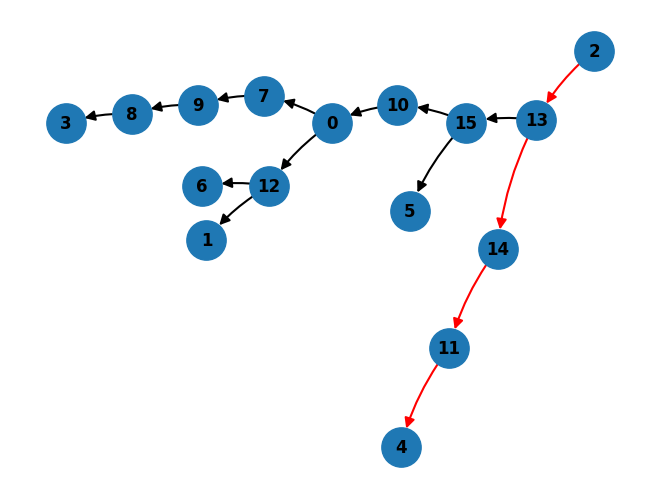

In [2]:
n_examples = 172_000
n_states = 16

dataset = GraphDataset(n_states, "dataset.txt", n_examples)
dataset.visualize_example(0)
train_loader, test_loader = get_loaders(dataset, 32)

In [3]:
cfg = HookedTransformerConfig(
    n_layers=6,
    d_model=128,
    n_ctx=dataset.max_seq_length - 1,
    n_heads=1,
    d_mlp=512,
    d_head=128,
    #attn_only=True,
    d_vocab=len(dataset.idx2tokens),
    device="cuda",
    attention_dir= "causal",
    act_fn="gelu",
)
model = HookedTransformer(cfg)


In [4]:
model_name="model.pt"

In [5]:
# Load in the model if weights are in the directory, else train new model
if os.path.exists(model_name):
    model.load_state_dict(torch.load(model_name))
else:
    train(model, train_loader, test_loader, n_epochs=100, learning_rate=3e-4)
    torch.save(model.state_dict(), model_name)

In [6]:
start_seed = 250_000
num_samples = 1_000

for order in ["forward", "backward", "random"]:
  total_correct = 0
  for seed in range(start_seed, start_seed + num_samples):
      graph = generate_example(16, seed, order=order)
      pred, correct = eval_model(model, dataset, graph)
      if correct:
        total_correct += 1      

  print(f"{order}: {100* total_correct / num_samples:.4f}%")

forward: 100.0000%
backward: 98.8000%
random: 99.9000%


In [8]:
acts, graphs = aggregate_activations(
        model=model,
        dataset=dataset,
        activation_keys=[],
        n_states=n_states,
        n_samples=5000,
        min_path_length=8
    )

In [12]:
#test_graph = generate_example(n_states, 5, order="random")
test_graph=graphs[0]
labels, test_cache = get_example_cache(test_graph, model, dataset)


NameError: name 'graphs' is not defined

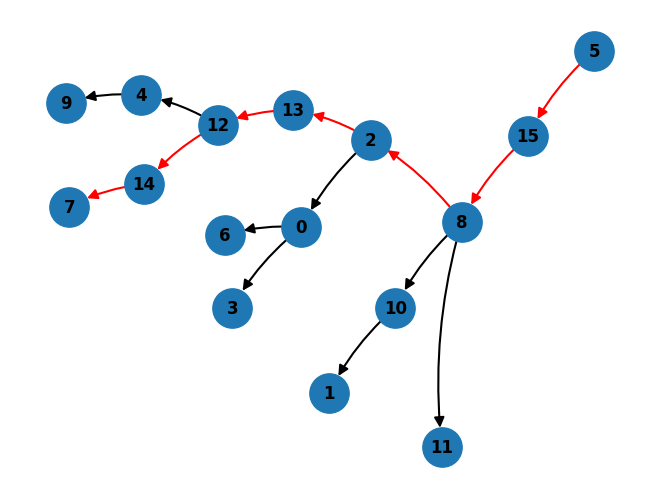

In [12]:
parse_example(test_graph)

In [8]:
labels, cache = get_example_cache(test_graph, model, dataset)

NameError: name 'test_graph' is not defined

In [7]:
def ablation_hook(
            resid_pre,
            hook):
        # Each HookPoint has a name attribute giving the name of the hook.
        resid_pre = resid_pre*0
        return resid_pre

In [15]:
test_cache

ActivationCache with keys ['hook_embed', 'hook_pos_embed', 'blocks.0.hook_resid_pre', 'blocks.0.ln1.hook_scale', 'blocks.0.ln1.hook_normalized', 'blocks.0.attn.hook_q', 'blocks.0.attn.hook_k', 'blocks.0.attn.hook_v', 'blocks.0.attn.hook_attn_scores', 'blocks.0.attn.hook_pattern', 'blocks.0.attn.hook_z', 'blocks.0.hook_attn_out', 'blocks.0.hook_resid_mid', 'blocks.0.ln2.hook_scale', 'blocks.0.ln2.hook_normalized', 'blocks.0.mlp.hook_pre', 'blocks.0.mlp.hook_post', 'blocks.0.hook_mlp_out', 'blocks.0.hook_resid_post', 'blocks.1.hook_resid_pre', 'blocks.1.ln1.hook_scale', 'blocks.1.ln1.hook_normalized', 'blocks.1.attn.hook_q', 'blocks.1.attn.hook_k', 'blocks.1.attn.hook_v', 'blocks.1.attn.hook_attn_scores', 'blocks.1.attn.hook_pattern', 'blocks.1.attn.hook_z', 'blocks.1.hook_attn_out', 'blocks.1.hook_resid_mid', 'blocks.1.ln2.hook_scale', 'blocks.1.ln2.hook_normalized', 'blocks.1.mlp.hook_pre', 'blocks.1.mlp.hook_post', 'blocks.1.hook_mlp_out', 'blocks.1.hook_resid_post', 'blocks.2.hook_re

### Useful functions

In [16]:
def logit_lens_hook(pred, model,dataset, lenses=None):
    # Get labels and cache

    labels, _ = get_example_cache(pred, model, dataset)
    tokens = torch.from_numpy(dataset.tokenize(pred)[0:-1]).cuda()
    _, cache = model.run_with_cache(tokens)
    # Calculate end idx of the labels
    end = num_last(labels, ",")
    # Get the logit lens for each layer's resid_post
    outs = []
    for layer in range(1, model.cfg.n_layers+1):
        if layer < model.cfg.n_layers:
            act_name = tl_util.get_act_name("normalized", layer, "ln1")
        else:
            act_name = "ln_final.hook_normalized"
        res_stream = cache[act_name][0]
        if lenses is not None:
            out_proj = res_stream @ lenses[act_name]
        else:
            out_proj = res_stream @ model.W_U
        out_proj = out_proj.argmax(-1)
        lens_out = [dataset.idx2tokens[i] for i in out_proj]
        outs.append([f"Layer {layer} LL"] + lens_out[47:end])
    # Plot data
    header = dict(values=["Current Input"] + labels[47:end])
    rows = dict(values=np.array(outs).T.tolist())
    table = go.Table(header=header, cells=rows)
    layout = go.Layout(width=1000, height=700)
    figure = go.Figure(data=[table], layout=layout)
    figure.show()

In [209]:
def logit_lens_hook_layer(pred, model,dataset,layer, lenses=None):
    # Get labels and cache

    labels, _ = get_example_cache(pred, model, dataset)
    tokens = torch.from_numpy(dataset.tokenize(pred)[0:-1]).cuda()
    _, cache = model.run_with_cache(tokens)
    # Calculate end idx of the labels
    end = num_last(labels, ",")
    # Get the logit lens for each layer's resid_post
    outs = []
    
    if layer < model.cfg.n_layers:
        act_name = tl_util.get_act_name("normalized", layer, "ln1")
    else:
        act_name = "ln_final.hook_normalized"
    res_stream = cache[act_name][0]
    if lenses is not None:
        out_proj = res_stream @ lenses[act_name]
    else:
        out_proj = res_stream @ model.W_U
        out_proj = out_proj
    # Plot data
    return out_proj


In [17]:
def logit_lens_correct_probs_hook(pred, model, dataset, position, lenses=None):
    # Get labels and cache
    labels, _ = get_example_cache(pred, model, dataset)
    tokens = torch.from_numpy(dataset.tokenize(pred)[0:-1]).cuda()
    _, cache = model.run_with_cache(tokens)
    probs = []
    correct_token = labels[position+1]
    correct_token_idx = dataset.tokens2idx[correct_token]
    for layer in range(1, model.cfg.n_layers+1):
        if layer < model.cfg.n_layers:
            act_name = tl_util.get_act_name("normalized", layer, "ln1")
        else:
            act_name = "ln_final.hook_normalized"
        res_stream = cache[act_name][0]
        if lenses is not None:
            out_proj = res_stream @ lenses[act_name]
        else:
            out_proj = res_stream @ model.W_U
            out_proj = out_proj.softmax(-1)
        probs.append( out_proj[position, correct_token_idx].item() )
    # Plot data
    return probs, correct_token ,labels

### Logit lens experiments 

In [77]:
acts, graphs = aggregate_activations(
        model=model,
        dataset=dataset,
        activation_keys=[],
        n_states=n_states,
        n_samples=10,
        min_path_length=13
    )

In [78]:
#test_graph = generate_example(n_states, 5, order="random")
test_graph=graphs[1]
labels, test_cache = get_example_cache(test_graph, model, dataset)

In [ ]:
for l in range(model.cfg.n_layers):
    for h in range(model.cfg.n_heads):
        fig = display_head(cache, labels, l, h, show=True)

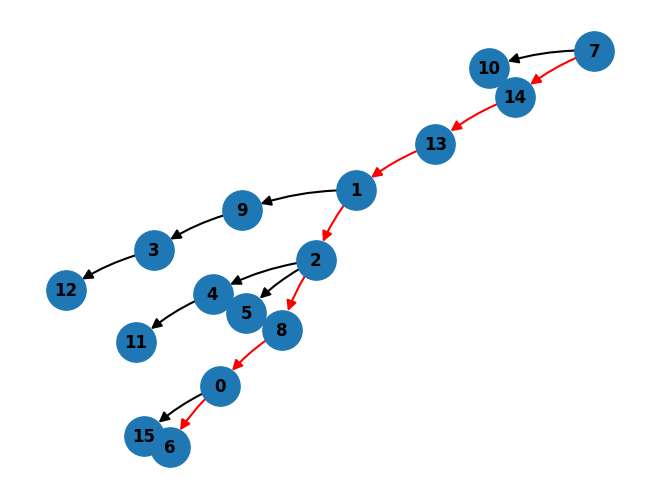

In [194]:
parse_example(test_graph)

In [108]:
test_graph

'3>2,4>5,8>3,14>4,14>8,11>14,7>11,15>7,12>15,6>12,10>6,13>9,13>10,0>13,1>0|2:1>0>13>10>6>12>15>7>11>14>8>3>2'

In [55]:
test_graph_backwards="5>2,5>3,3>1,1>0,0>14,0>9,9>6, 6>10,10>7,7>4,4>15,15>11,11>8,8>12,8>13|13:5>3>1>0>9>6>10>7>4>15>11>8>13"

In [81]:
def generate_goal_distance_examples(distance):
    # Generate clean and corrupted prompts
    clean_prompt = "0>1,1>2,2>3,3>4,4>5,5>6,6>7,7>8,8>9,9>10,10>11,11>12,12>13,13>14,14>15|15:0>1>2>3>4>5>6>7>8>9>10>11>12>13>14>15"
    edges = [f"{i}>{i+1}" for i in range(15 - distance - 1)] + [f"{15 - distance - 1}>{15 - distance}", f"{15 - distance - 1}>{15 - distance + 1}"] + [f"{i}>{i+1}" for i in range(15 - distance + 1, 15)]
    path = '>'.join([str(x) for x in range(16) if x != 15 - distance])
    corrupted_prompt = ",".join(edges) + "|" + f"{15}:{path}"
    return clean_prompt, corrupted_prompt

In [102]:
test_graph_line,test_graph_line_corrupted = generate_goal_distance_examples(8)

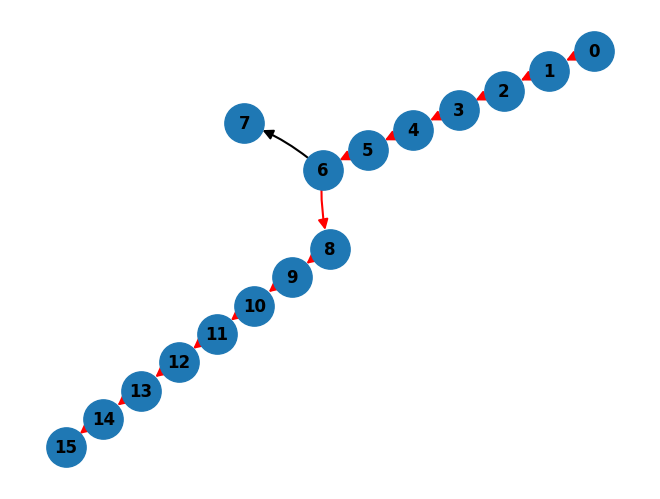

In [103]:
parse_example(test_graph_line_corrupted)

In [211]:
test_graph = generate_example(n_states, 5, order="forward")
labels, test_cache = get_example_cache(test_graph, model, dataset)

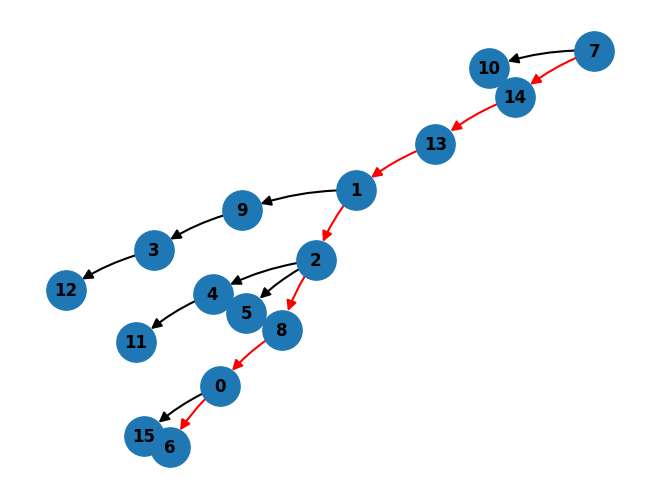

In [187]:
parse_example(test_graph)

In [230]:
model.reset_hooks()

In [251]:
logits_ordered=dataset.idx2tokens[:3]+dataset.idx2tokens[9:19] +dataset.idx2tokens[3:9]+dataset.idx2tokens[19:]

In [273]:
logits=logit_lens_hook_layer(test_graph,model,dataset,layer=5, lenses=None)
imshow(logits,x=logits_ordered,y=[f"{index}: {label}" for index, label in enumerate(labels)])

In [277]:
logits=logit_lens_hook_layer(test_graph_line,model,dataset,layer=5, lenses=None)
imshow(logits,x=logits_ordered,y=[f"{index}: {label}" for index, label in enumerate(test_graph_line)])

ValueError: The length of the y vector must match the length of the first dimension of the img matrix.

In [258]:
logits=logit_lens_hook_layer(test_graph,model,dataset,layer=5, lenses=None)
imshow(torch.softmax(logits,0),x=dataset.idx2tokens)

In [238]:
logits=logit_lens_hook_layer(test_graph_line,model,dataset,layer=3, lenses=None)
imshow(torch.softmax(logits,0),x=dataset.idx2tokens)

In [213]:
logit_lens_hook(test_graph,model,dataset, lenses=lenses)

In [227]:
logit_lens_hook(test_graph_line,model,dataset, lenses=None)

In [171]:
cache

ActivationCache with keys ['hook_embed', 'hook_pos_embed', 'blocks.0.hook_resid_pre', 'blocks.0.ln1.hook_scale', 'blocks.0.ln1.hook_normalized', 'blocks.0.attn.hook_q', 'blocks.0.attn.hook_k', 'blocks.0.attn.hook_v', 'blocks.0.attn.hook_attn_scores', 'blocks.0.attn.hook_pattern', 'blocks.0.attn.hook_z', 'blocks.0.hook_attn_out', 'blocks.0.hook_resid_mid', 'blocks.0.ln2.hook_scale', 'blocks.0.ln2.hook_normalized', 'blocks.0.mlp.hook_pre', 'blocks.0.mlp.hook_post', 'blocks.0.hook_mlp_out', 'blocks.0.hook_resid_post', 'blocks.1.hook_resid_pre', 'blocks.1.ln1.hook_scale', 'blocks.1.ln1.hook_normalized', 'blocks.1.attn.hook_q', 'blocks.1.attn.hook_k', 'blocks.1.attn.hook_v', 'blocks.1.attn.hook_attn_scores', 'blocks.1.attn.hook_pattern', 'blocks.1.attn.hook_z', 'blocks.1.hook_attn_out', 'blocks.1.hook_resid_mid', 'blocks.1.ln2.hook_scale', 'blocks.1.ln2.hook_normalized', 'blocks.1.mlp.hook_pre', 'blocks.1.mlp.hook_post', 'blocks.1.hook_mlp_out', 'blocks.1.hook_resid_post', 'blocks.2.hook_re

In [183]:
model.reset_hooks()
temp_hook_fn = ablation_hook

#model.blocks[5].hook_resid_mid.add_hook(temp_hook_fn)
#model.blocks[4].hook_resid_mid.add_hook(temp_hook_fn)
#model.blocks[4].mlp.hook_post.add_hook(temp_hook_fn)
#model.blocks[5].mlp.hook_post.add_hook(temp_hook_fn)
#model.blocks[5].hook_resid_mid.add_hook(temp_hook_fn)
#model.blocks[5].hook_attn_out.add_hook(temp_hook_fn)
model.blocks[4].hook_attn_out.add_hook(temp_hook_fn)

In [184]:
logit_lens_hook(test_graph,model,dataset, lenses=None)

In [155]:
model.reset_hooks()
temp_hook_fn = ablation_hook
#
#model.blocks[4].hook_attn_out(temp_hook_fn)
#model.blocks[5].hook_attn_out(temp_hook_fn)
#model.blocks[4].mlp.hook_post.add_hook(temp_hook_fn)
#model.blocks[5].mlp.hook_post.add_hook(temp_hook_fn)
model.blocks[4].ln1.hook_normalized.add_hook(temp_hook_fn)

In [131]:
cache

ActivationCache with keys ['hook_embed', 'hook_pos_embed', 'blocks.0.hook_resid_pre', 'blocks.0.ln1.hook_scale', 'blocks.0.ln1.hook_normalized', 'blocks.0.attn.hook_q', 'blocks.0.attn.hook_k', 'blocks.0.attn.hook_v', 'blocks.0.attn.hook_attn_scores', 'blocks.0.attn.hook_pattern', 'blocks.0.attn.hook_z', 'blocks.0.hook_attn_out', 'blocks.0.hook_resid_mid', 'blocks.0.ln2.hook_scale', 'blocks.0.ln2.hook_normalized', 'blocks.0.mlp.hook_pre', 'blocks.0.mlp.hook_post', 'blocks.0.hook_mlp_out', 'blocks.0.hook_resid_post', 'blocks.1.hook_resid_pre', 'blocks.1.ln1.hook_scale', 'blocks.1.ln1.hook_normalized', 'blocks.1.attn.hook_q', 'blocks.1.attn.hook_k', 'blocks.1.attn.hook_v', 'blocks.1.attn.hook_attn_scores', 'blocks.1.attn.hook_pattern', 'blocks.1.attn.hook_z', 'blocks.1.hook_attn_out', 'blocks.1.hook_resid_mid', 'blocks.1.ln2.hook_scale', 'blocks.1.ln2.hook_normalized', 'blocks.1.mlp.hook_pre', 'blocks.1.mlp.hook_post', 'blocks.1.hook_mlp_out', 'blocks.1.hook_resid_post', 'blocks.2.hook_re

In [192]:
imshow(cache['blocks.5.ln1.hook_normalized'][0])

In [123]:
probabilities=[]
for i in range(47,64):
    probs, correct_token ,labels =logit_lens_correct_probs_hook(test_graph,model,dataset,i, lenses=None)
    probabilities.append(probs)
print(len(probabilities))
print(len(labels[47:64]))
imshow(np.array(probabilities).T,x=labels[47:64])


17
17


In [70]:
probabilities=[]
for i in range(47,64):
    probs_random, correct_token ,labels =logit_lens_correct_probs_hook(test_graph,model,dataset,i, lenses=None)
    probs_backward, correct_token ,labels =logit_lens_correct_probs_hook(test_graph_backwards,model,dataset,i, lenses=None)
    
    probabilities.append(np.array(probs_random)-np.array(probs_backward))
print(len(probabilities))
print(len(labels[47:64]))
imshow(np.array(probabilities).T,x=labels[47:64])


17
17


In [6]:
model.reset_hooks()
temp_hook_fn = ablation_hook

#model.blocks[5].hook_resid_mid.add_hook(temp_hook_fn)
#model.blocks[4].hook_resid_mid.add_hook(temp_hook_fn)
#model.blocks[4].mlp.hook_post.add_hook(temp_hook_fn)
#model.blocks[5].mlp.hook_post.add_hook(temp_hook_fn)
#model.blocks[5].hook_resid_mid.add_hook(temp_hook_fn)

NameError: name 'ablation_hook' is not defined

In [ ]:
temp_hook_fn = ablation_hook
for layer in range(6):
    probabilities=[]
    for i in range(47,64):
        model.reset_hooks()
        model.blocks[layer].mlp.hook_post.add_hook(temp_hook_fn)
        probs, correct_token ,labels =logit_lens_correct_probs_hook(test_graph,model,dataset,i, lenses=None)
        probabilities.append(probs)
    print(f"layer{layer}")
    imshow(np.array(probabilities).T,x=labels[47:64])


In [ ]:
temp_hook_fn = ablation_hook
for layer in range(6):
    probabilities=[]
    for i in range(47,64):
        model.reset_hooks()
        model.blocks[layer].mlp.hook_post.add_hook(temp_hook_fn)
        probs, correct_token ,labels =logit_lens_correct_probs_hook(test_graph,model,dataset,i, lenses=None)
        probabilities.append(probs)
    print(f"layer{layer}")
    imshow(np.array(probabilities).T,x=labels[47:64])


### Test ablate mlp 0


In [ ]:
temp_hook_fn = ablation_hook
for example in range(100):
    probabilities=[]
    graph = generate_example(n_states, example, order="random")
    for i in range(47,64):
        model.reset_hooks()
        model.blocks[0].mlp.hook_post.add_hook(temp_hook_fn)
        probs, correct_token ,labels =logit_lens_correct_probs_hook(graph,model,dataset,i, lenses=None)
        probabilities.append(probs)
    print(f"example{example}")
    imshow(np.array(probabilities).T,x=labels[47:64])

In [ ]:
temp_hook_fn = ablation_hook
model.reset_hooks()
model.blocks[1].mlp.hook_post.add_hook(temp_hook_fn)
for example in range(100):
    probabilities=[]
    graph = generate_example(n_states, example, order="random")
    for i in range(47,64):
        probs, correct_token ,labels =logit_lens_correct_probs_hook(graph,model,dataset,i, lenses=None)
        probabilities.append(probs)
    print(f"example {example}")
    imshow(np.array(probabilities).T,x=labels[47:64])

### Tuned lens

In [62]:
lenses = calculate_tuned_lens(model, dataset)

0.566595696853088
0.5849585388480857
0.6155965433107694
0.7173246475456008
0.8584950983418594
0.9717800074372759


In [ ]:
probabilities=[]
for i in range(47,64):
    probs, correct_token ,labels =logit_lens_correct_probs_hook(pred,model,dataset,i, lenses=lenses)
    probabilities.append(probs)
print(len(probabilities))
print(len(labels[47:64]))
imshow(np.array(probabilities).T,x=labels[47:64])


17
17


In [23]:
model.reset_hooks()
temp_hook_fn = ablation_hook
model.blocks[4].hook_resid_post.add_hook(temp_hook_fn)

In [24]:
start_seed = 250_000
num_samples = 100

for order in ["forward", "backward", "random"]:
  total_correct = 0
  for seed in range(start_seed, start_seed + num_samples):
      graph = generate_example(16, seed, order=order)
      pred, correct = eval_model(model, dataset, graph)
      if correct:
        total_correct += 1      

  print(f"{order}: {100* total_correct / num_samples:.4f}%")

forward: 0.0000%
backward: 0.0000%
random: 0.0000%


In [ ]:
start_seed = 250_000
num_samples = 1_000
X, graphs = aggregate_activations(
    model=model,
    dataset=dataset,
    activation_keys=[utils.get_act_name("v", i, "attn") for i in range(0, 6)],
    n_states=n_states,
    n_samples=num_samples
)


total_correct = 0
for graph in graphs:
      pred, correct = eval_model(model, dataset, graph)
      if correct:
        total_correct += 1      

print(f"{order}: {100* total_correct / num_samples:.4f}%")

In [ ]:
logit_lens_hook(pred, model)

TypeError: logit_lens_hook() missing 1 required positional argument: 'dataset'